In [2]:
import argparse
import importlib
import os
import random
import time
from distutils.util import strtobool

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import gymnasium as gym
import numpy as np
import supersuit as ss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

from gym_multi_car_racing import multi_car_racing_bezier
from vector.vector_constructors import concat_vec_envs


def parse_args():
    # fmt: off
    parser = argparse.ArgumentParser(allow_abbrev=False)

    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="multi_car_racing",
        help="the id of the environment")
    parser.add_argument("--seed", type=int, default=123,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    parser.add_argument("--num-episodes", type=int, default=10,
        help="number of episodes to test")
    parser.add_argument("--model-path", type=str, default=None,
        help="path to the model to be tested")
    parser.add_argument("--track-name", type=str, default=None,
        help="Formula 1 track name")
    parser.add_argument("--num-agents", type=int, default=2,
        help="number of agents in the environment")
    parser.add_argument("--frame-stack", type=int, default=4,
        help="number of stacked frames")
    parser.add_argument("--frame-skip", type=float, default=4,
        help="number of frames to skip (repeat action)")
    parser.add_argument("--num-envs", type=int, default=16,  # 16
        help="the number of parallel game environments")
    parser.add_argument("--discrete-actions", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="Whether to use a discrete action space")
    parser.add_argument("--render", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="Whether to render the environment")
    args, unknown = parser.parse_known_args()
    # fmt: on
    return args


def make_env():

    render_mode = "human" if args.render else "state_pixels"

    # env setup
    env = multi_car_racing_bezier.parallel_env(n_agents=args.num_agents, render_mode=render_mode,
                                               use_random_direction=False,
                                               discrete_action_space=args.discrete_actions, verbose=0)
    
    if not args.discrete_actions:
        env = ss.clip_actions_v0(env)
    if args.frame_skip > 1:
        env = ss.frame_skip_v0(env, args.frame_skip)
    if args.frame_stack > 1:
        env = ss.frame_stack_v1(env, args.frame_stack)
    if args.clip_rewards:
        env.render_mode = None
        env = ss.clip_reward_v0(env, lower_bound=-3, upper_bound=3)
    env = ss.pettingzoo_env_to_vec_env_v1(env)

    return env


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(12, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
        )
        if args.discrete_actions:
            self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
            self.critic = layer_init(nn.Linear(512, 1), std=1)
        else:
            self.actor_mean = layer_init(nn.Linear(512, np.prod(envs.single_action_space.shape)), std=0.01)
            self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))
            self.critic = layer_init(nn.Linear(512, 1), std=1)

    def get_value(self, x):
        return self.critic(self.network(x.permute((0, 3, 1, 2)) / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x.permute((0, 3, 1, 2)) / 255.0)
        if args.discrete_actions:
            logits = self.actor(hidden)
            probs = Categorical(logits=logits)
            if action is None:
                action = probs.sample()
            return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)
        else:
            action_mean = self.actor_mean(hidden)
            action_logstd = self.actor_logstd.expand_as(action_mean)
            action_std = torch.exp(action_logstd)
            probs = Normal(action_mean, action_std)
            if action is None:
                action = probs.sample()
            return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(hidden)

In [3]:
# Enable autoreload
%load_ext autoreload

In [5]:
# Load tracks
X = np.load("X_30k.npy")
X = X*30  # Rescale
X.shape

(30000, 12, 2)

In [6]:
%autoreload 2

In [7]:
def map_envs_to_pipes(idx_starts, num_envs):
    num_pipes = len(idx_starts) - 1
    envs_per_pipe = int(np.ceil(num_envs / num_pipes))

    envs_pipes = np.ones((num_pipes, envs_per_pipe))*(-1)

    for i in range(envs_pipes.shape[0]):
        envs_pipes[i, :] = np.arange(idx_starts[i], idx_starts[i+1])
    
    return envs_pipes

def get_env_position(env_num, envs_pipes):
    return [e[0] for e in np.where(envs_pipes == env_num)]

def set_control_points(envs, env_num, control_points):
    envs_pipes = map_envs_to_pipes(envs.idx_starts, envs.num_envs)
    pipe, pos = get_env_position(env_num, envs_pipes)
    envs.pipes[pipe].send(("set_control_points", (pos, control_points)))
    envs.pipes[pipe].recv()

In [8]:
args = parse_args()

args.model_path = "models/trained-agent_2640000-steps.pt"
args.num_agents = 1
args.num_envs = 5
args.render = False
args.clip_rewards = False
args.num_cpus = 8

print(args)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
print("Device:", device)

# env setup
envs = concat_vec_envs(make_env, args.num_envs, num_cpus=args.num_cpus)
print("Observation space:", envs.observation_space)
print("Action space:", envs.action_space)
envs.single_observation_space = envs.observation_space
envs.single_action_space = envs.action_space
envs.is_vector_env = True
envs.single_observation_space = envs.observation_space
envs.single_action_space = envs.action_space
envs.is_vector_env = True

agent = Agent(envs).to(device)
agent.load_state_dict(torch.load(args.model_path))

# Run
if os.path.exists("returns_30k.npy"):
    returns = np.load("returns_30k.npy")
else:
    returns = np.zeros((X.shape[0], args.num_envs))

# Start track
start_index = 20_000

# Set first track
for i in range(args.num_envs):
    set_control_points(envs, i, X[start_index])

next_obs, info = envs.reset(seed=args.seed)
next_obs = torch.Tensor(next_obs).to(device)
episode_return = np.zeros(args.num_envs)
episode_length = np.zeros(args.num_envs).astype(int)

total_track_count = start_index
envs_track_count = np.ones(args.num_envs).astype(int)*(start_index)

while total_track_count < X.shape[0]:

    action, _, _, _ = agent.get_action_and_value(next_obs)
    next_obs, reward, done, truncation, info = envs.step(action.cpu().numpy())
    next_obs = torch.Tensor(next_obs).to(device)
    episode_return += reward
    episode_length += 1

    for i in range(args.num_envs):
        if done[i]:
            # Add results to arrays
            returns[envs_track_count[i], i] = episode_return[i]
            print(f"Env {i} done with track {envs_track_count[i]}, reward: {episode_return[i]}, length: {episode_length[i]}")
            # Increase counters
            envs_track_count[i] += 1
            # Set new track
            set_control_points(envs, i, X[envs_track_count[i]])
            # Reset episode
            episode_length[i] = 0
            episode_return[i] = 0

    total_track_count = np.min(envs_track_count)

    # Save every 50 tracks
    if total_track_count % 50 == 0:
        np.save("returns_30k.npy", returns)

Namespace(clip_rewards=False, cuda=True, discrete_actions=False, env_id='multi_car_racing', frame_skip=4, frame_stack=4, model_path='models/trained-agent_2640000-steps.pt', num_agents=1, num_cpus=8, num_envs=5, num_episodes=10, render=False, seed=123, torch_deterministic=False, track_name=None)
Device: cuda


Observation space: Box(0, 255, (84, 84, 12), uint8)
Action space: Box([-1.  0.  0.], 1.0, (3,), float32)
Env 0 done with track 20000, reward: 548.7222683653235, length: 251
Env 1 done with track 20000, reward: 655.788653485477, length: 251
Env 2 done with track 20000, reward: 512.3197062537074, length: 251
Env 3 done with track 20000, reward: 512.3197020217776, length: 251
Env 4 done with track 20000, reward: 398.8293376788497, length: 251
Env 0 done with track 20001, reward: 407.3946472629905, length: 251
Env 1 done with track 20001, reward: 632.2340496703982, length: 251
Env 2 done with track 20001, reward: 512.3197023496032, length: 251
Env 3 done with track 20001, reward: 570.1355508863926, length: 251
Env 4 done with track 20001, reward: 653.6473263427615, length: 251
Env 0 done with track 20002, reward: 358.14411249011755, length: 251
Env 1 done with track 20002, reward: 499.47173135727644, length: 251
Env 2 done with track 20002, reward: 510.17837458103895, length: 251
Env 3 don

In [18]:
%autoreload 2

In [9]:
returns = np.load("returns.npy")

In [10]:
# Filter rows that are not zeros
num_done_tracks = returns[~np.all(returns == 0, axis=1)].shape[0]
num_done_tracks

11951

In [11]:
from gym_multi_car_racing import bezier
from gymnasium.utils import seeding
import matplotlib.pyplot as plt

np_random, seed = seeding.np_random(7)

def get_track(control_points=None, np_random=np_random):
    if control_points is not None:
        a = np.array(control_points)
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.2, numpoints=40)
    else:
        a = bezier.get_random_points(n=12, scale=PLAYFIELD, mindst=None, np_random=np_random) // 30 * 30
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.2, numpoints=40)

    x, y = np.clip(0, x.max(), x), np.clip(0, y.max(), y)

    return a, x, y

def plot_track(track, checkpoints=None):
    # Plot track
    plt.plot(track[:,1], track[:,0], linewidth=9, color=[0.4, 0.4, 0.4])

    # Plot checkpoints
    if checkpoints is not None:
        for i in range(len(checkpoints)):
            y, x = checkpoints[i,:]
            plt.plot(x, y, 'o', markersize=2, color="tab:orange")
            plt.text(x, y, str(i), fontsize=10, color="black")
    
    plt.xlim(-20,360)
    plt.ylim(-20,360)

    ax = plt.gca()
    ax.set_facecolor(np.array([102, 230, 102])/255.)

from PIL import Image, ImageDraw
import numpy as np
import cv2

def get_image_(points, img_size=(32, 32)):
    """
    Create a 2D image of a curve using a set of points.

    Parameters:
    - points: List of tuples representing (x, y) coordinates of the curve.
    - img_size: Tuple representing the size of the image (width, height).

    Returns:
    - img_array: NumPy array representing the image.

    Example:
    >>> points = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16)]
    >>> image_array = get_image(points)
    """
    # Find the bounding box of the points
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)

    # Create a blank image with a black background
    width = int(max_x - min_x) + 20
    height = int(max_y - min_y) + 20
    image = Image.new("RGB", (width, height), "black")
    draw = ImageDraw.Draw(image)

    # Translate points to the image coordinates
    translated_points = [(x - min_x + 10, y - min_y + 10) for x, y in points]

    # Draw the curve on the image
    draw.line(translated_points, fill="white", width=2)

    # Convert the PIL image to a NumPy array
    img_array = np.array(image)

    # Convert to grayscale
    img_array = np.mean(img_array, axis=2)

    # Resize image
    width, height = img_size
    img_array = cv2.resize(img_array, dsize=(width, height), interpolation=cv2.INTER_AREA)

    # Normalize pixel values
    img_array = img_array / img_array.max()

    return img_array

In [12]:
complexities = np.load("complexities.npy")

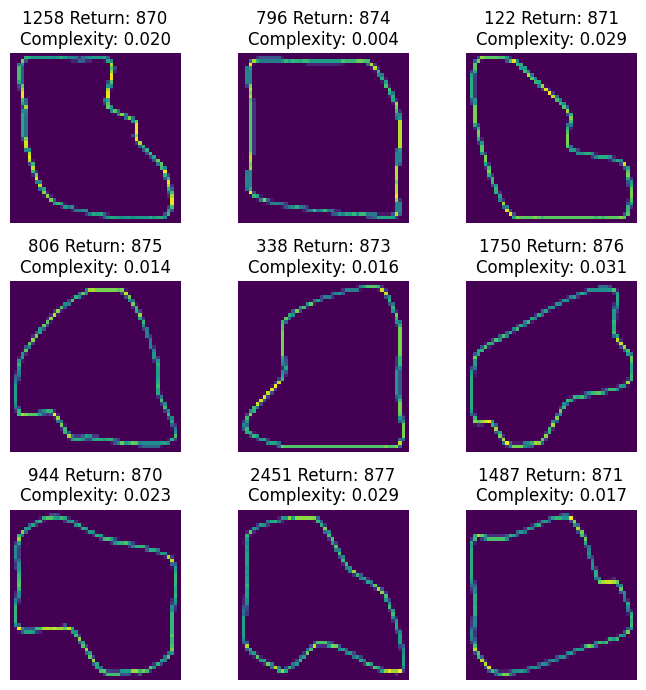

In [18]:
indices = np.random.choice(np.where(returns.mean(axis=1) > 0)[0], size=9, replace=False)
indices = np.random.choice(np.where((returns.mean(axis=1) > 870) & (np.array(returns).mean(axis=1) > 0))[0], size=9, replace=False)
#indices = np.arange(start_index, start_index + 9)

plt.figure(figsize=(7,7))

for i, index in enumerate(indices):
    plt.subplot(3,3,i+1)
    checkpoints, x, y = get_track(control_points=X[index])
    track = np.array([x, y]).T
    img = get_image_(track, img_size=(48, 48))
    plt.imshow(img)
    plt.title(f"{index} Return: {np.array(returns).mean(axis=1)[index]:1.0f}\nComplexity: {complexities[index]:.3f}")
    plt.axis('off')
plt.tight_layout()

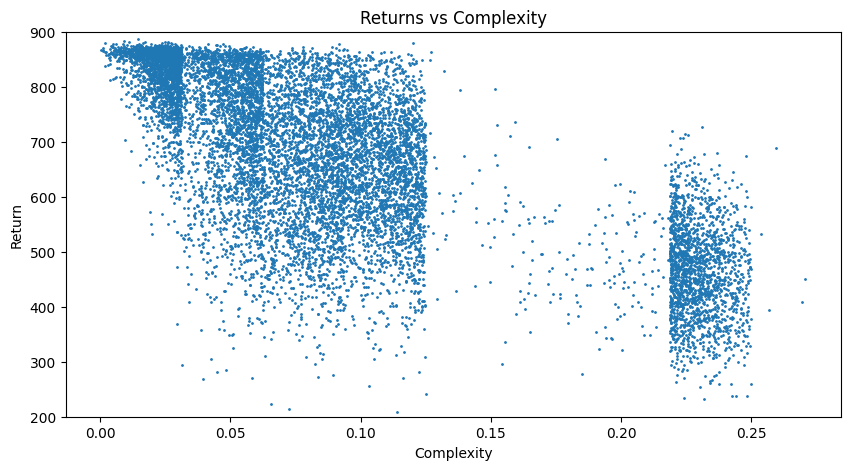

In [17]:
returns_mean = np.array(returns).mean(axis=1)

# Plot returns vs complexity
plt.figure(figsize=(10,5))
plt.scatter(complexities, returns_mean, s=1)
plt.ylim(200,900)
plt.xlabel("Complexity")
plt.ylabel("Return")
plt.title("Returns vs Complexity")
plt.show()

(-0.5, 47.5, 47.5, -0.5)

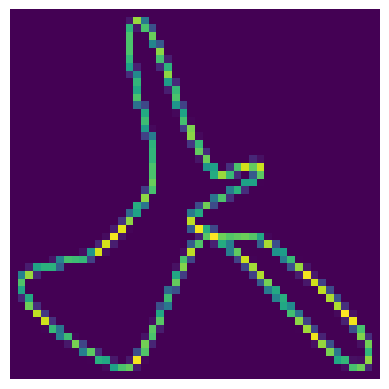

In [12]:
index = 28

checkpoints, x, y = get_track(control_points=control_points[index])
track = np.array([x, y]).T
img = get_image_(track, img_size=(48, 48))
plt.imshow(img)
plt.title(f"{index} Return: {returns[index]:1.0f}")
plt.axis('off')